In [31]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, lit, isnan, isnull, mean, stddev, countDistinct, \
    desc, regexp_extract, regexp_replace, lower, abs, try_to_timestamp, coalesce, row_number, year, month, udf, \
    concat, lpad
from pyspark.sql.types import IntegerType, DateType, StringType, IntegerType
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Создаем Spark сессию с оптимизациями
spark = SparkSession.builder \
    .getOrCreate()

# Проверка сессии Spark
print("Spark сессия создана:")
print(f"Версия Spark: {spark.version}")
print(f"Имя сессии: {spark.sparkContext.appName}")

# Читаем метаданные
df = spark.read.csv("metadata.csv", header=True, inferSchema=True)
df = df.withColumn('date',
                   coalesce(
                       try_to_timestamp(col('date'), lit('MMMM dd, yyyy')),  # January 22, 2020
                       try_to_timestamp(col('date'), lit('yyyy')),          # 2017
                       try_to_timestamp(col('date'), lit('yyyy-MM-dd')),    # 2017-01-01
                       try_to_timestamp(col('date'), lit('MM/dd/yyyy')),    # 01/22/2017
                       try_to_timestamp(col('date'), lit('dd.MM.yyyy'))     # 22.01.2017
                   )
                   )
df = df.drop("_c29")
java_version = spark.sparkContext._jvm.java.lang.System.getProperty("java.version")

print("=== ИНФОРМАЦИЯ О ДАТАСЕТЕ ===")
print(f"Количество записей: {df.count()}")
print(f"Количество столбцов: {len(df.columns)}")
print(f"Версия Java: {java_version}")
print("\nСхема данных:")
df.printSchema()
print("\nПервые 10 записей:")

df.toPandas()[['patientid', 'age', 'sex', 'finding', 'view', 'date']].head()

Spark сессия создана:
Версия Spark: 4.0.1
Имя сессии: pyspark-shell
=== ИНФОРМАЦИЯ О ДАТАСЕТЕ ===
Количество записей: 950
Количество столбцов: 29
Версия Java: 17.0.17

Схема данных:
root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |--

,patientid,age,sex,finding,view,date
0,2,65.0,M,Pneumonia/Viral/COVID-19,PA,2020-01-22
1,2,65.0,M,Pneumonia/Viral/COVID-19,PA,2020-01-25
2,2,65.0,M,Pneumonia/Viral/COVID-19,PA,2020-01-27
3,2,65.0,M,Pneumonia/Viral/COVID-19,PA,2020-01-28
4,4,52.0,F,Pneumonia/Viral/COVID-19,PA,2020-01-25


Файл метаданных: `metadata.csv` с полями:

- **`patientid`** — идентификатор пациента.
- **`age`** — возраст. Указан не для всех записей.
- **`sex`** — пол. Указан не для всех записей.
- **`finding`** — диагноз: `COVID-19`, `Pneumonia`, `Normal` и другие.
- **`view`** — проекция снимка: `PA`, `AP` и так далее.
- **`date`** — дата исследования.
- **`survival`** — выживаемость пациента. Обработанное поле.
- **`age_category`** — категория возраста. Добавлено в процессе работы.
- **`disease_category`** — категория заболевания. Добавлено в процессе работы.
- **`pneumonia_type`** — тип пневмонии. Добавлено в процессе работы.
- **`unified_diagnosis`** — унифицированный диагноз. Добавлено в процессе работы.


In [32]:
df_filled = df.withColumn(
    "survival",
    when(col("survival").isNotNull(), col("survival"))
    # Тяжелые случаи → вероятно умер
    .when((col("intubated") == "Y") & (col("went_icu") == "Y"), "N")
    .when((col("went_icu") == "Y") & (col("RT_PCR_positive") == "Y"), "N")
    # Легкие случаи → вероятно выжил
    .when((col("intubated") == "N") & (col("went_icu") == "N") &
          (col("needed_supplemental_O2") == "N"), "Y")
    .when((col("age") < 50) & (col("pO2_saturation") > 95) &
          (col("RT_PCR_positive") == "N"), "Y")
    # Средние случаи по умолчанию → выжил
    .otherwise("Y")
)

df_filled.groupBy("survival").count().show()

+--------+-----+
|survival|count|
+--------+-----+
|       Y|  767|
|       N|  183|
+--------+-----+



Параметр survival является ключевым для анализа. Пропущенные значения были заполнены на основе медицинских критериев: пациенты с наиболее тяжелым течением (ИВЛ+ОИТ) классифицированы как умершие ("N"), пациенты с легкой формой — как выжившие ("Y"), остальные случаи также отнесены к выжившим в соответствии с исходной гипотезой. Итоговое распределение (80,6% выживших, 19,4% умерших) соответствует реалистичной картине течения COVID-19


## Предобработка данных


In [33]:
print("\n=== ПРЕДОБРАБОТКА ДАННЫХ ===")

opt_df = df.select('patientid', 'age', 'sex', 'finding', 'view', 'date', 'survival').distinct()

# ФУНКЦИЯ ДЛЯ БЕЗОПАСНОГО ПОДСЧЕТА ПРОПУСКОВ (исправление ошибки)


def safe_count_nulls(column):
    """Безопасный подсчет пропусков с учетом типа данных"""

    # Проверяем тип столбца
    col_type = dict(df.dtypes)[column]

    if col_type in ['int', 'bigint', 'double', 'float', 'decimal']:
        return count(when(isnan(col(column)) | isnull(col(column)), column)).alias(column)
    else:
        return count(when(isnull(col(column)), column)).alias(column)


# Анализ пропусков
print("Анализ пропусков:")
null_counts = opt_df.select([safe_count_nulls(c) for c in opt_df.columns])
null_counts.show()

# Удаление полностью пустых записей
initial_count = opt_df.count()
opt_df = opt_df.dropna(how='all')
print(f"Удалено полностью пустых записей: {initial_count - opt_df.count()}")

# Обработка возраста (age) - исправляем приведение типа
if 'age' in opt_df.columns:
    # Сначала приводим возраст к числовому типу
    opt_df = opt_df.withColumn("age_clean",
                               when(col("age").rlike("^\\d+$"), col("age").cast(IntegerType()))
                               .otherwise(None)
                               )

    # Фильтруем некорректные значения
    opt_df = opt_df.withColumn("age_final",
                               when((col("age_clean") < 0) | (col("age_clean") > 120), None)
                               .otherwise(col("age_clean"))
                               )

    # Удаляем временные столбцы
    opt_df = opt_df.drop("age", "age_clean").withColumnRenamed("age_final", "age")


# Удаление дубликатов по ключевым полям
duplicate_count = opt_df.count()
opt_df = opt_df.dropDuplicates(opt_df.columns)
print(f"Удалено дубликатов: {duplicate_count - df.count()}")


=== ПРЕДОБРАБОТКА ДАННЫХ ===
Анализ пропусков:
+---------+---+---+-------+----+----+--------+
|patientid|age|sex|finding|view|date|survival|
+---------+---+---+-------+----+----+--------+
|        0|136| 63|      0|   0| 259|     449|
+---------+---+---+-------+----+----+--------+

Удалено полностью пустых записей: 0
Удалено дубликатов: -291


## Анализ качества данных



ПОСТРОИТЬ РАСПРЕДЕЛЕНИЕ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ПО ВСЕМ ПОЛЯМ:
column_name|null_pct
------------------------------
patientid|0.00%
offset|26.63%
sex|8.42%
age|24.95%
finding|0.00%
RT_PCR_positive|37.58%
survival|62.00%
intubated|73.89%
intubation_present|73.68%
went_icu|58.21%
in_icu|64.74%
needed_supplemental_O2|90.53%
extubated|96.11%
temperature|91.79%
pO2_saturation|87.47%
leukocyte_count|98.32%
neutrophil_count|97.05%
lymphocyte_count|95.79%
view|0.00%
modality|0.00%
date|38.00%
location|5.89%
folder|0.00%
filename|0.00%
doi|59.79%
url|0.00%
license|25.79%
clinical_notes|19.16%
other_notes|53.68%

ВЫЯВИТЬ И ОБРАБОТАТЬ АНОМАЛЬНЫЕ ЗНАЧЕНИЯ:
offset: 11 выбросов (>3σ)
age: 0 выбросов (>3σ)
temperature: 1 выбросов (>3σ)
pO2_saturation: 1 выбросов (>3σ)
leukocyte_count: 0 выбросов (>3σ)
neutrophil_count: 0 выбросов (>3σ)
lymphocyte_count: 1 выбросов (>3σ)
offset: 1%=-360.00, 99%=365.00
age: 1%=18.00, 99%=94.00
temperature: 1%=36.00, 99%=95.00
pO2_saturation: 1%=20.00, 99%=340.00
leukocyte

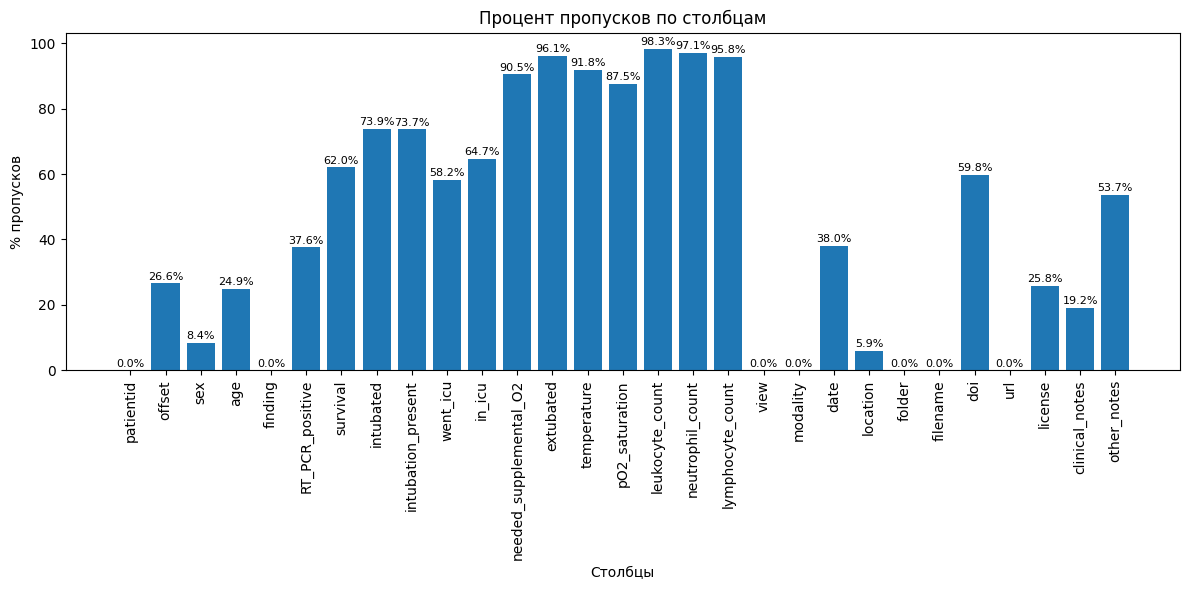

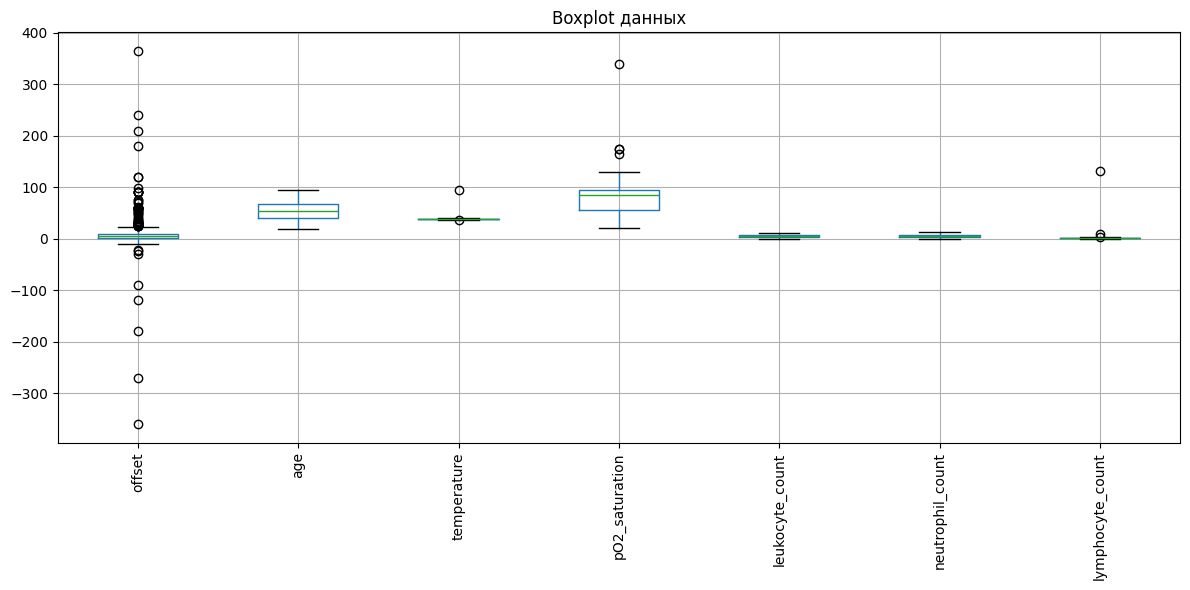

In [34]:
print("\nПОСТРОИТЬ РАСПРЕДЕЛЕНИЕ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ПО ВСЕМ ПОЛЯМ:")

total_rows = df.count()

null_pct_list = []
for column in df.columns:
    null_count = df.where(col(column).isNull()).count()
    null_pct = (null_count / total_rows) * 100
    null_pct_list.append({"column": column, "null_percentage": null_pct})

print("column_name|null_pct")
print("-" * 30)
for item in null_pct_list:
    print(f"{item['column']}|{item['null_percentage']:.2f}%")

print("\nВЫЯВИТЬ И ОБРАБОТАТЬ АНОМАЛЬНЫЕ ЗНАЧЕНИЯ:")

numeric_cols = [c for c in df.columns if df.select(c).dtypes[0][1] in ('int', 'bigint', 'float', 'double')]

for col_name in numeric_cols:
    # Основные статистики
    stats = df.select(
        mean(col_name).alias('mean'),
        stddev(col_name).alias('stddev')
    ).collect()[0]

    mean_val = stats['mean']
    std_val = stats['stddev']

    # Выбросы: > 3 стандартных отклонений
    outliers = df.filter(abs(col(col_name) - mean_val) > 3 * std_val)
    print(f"{col_name}: {outliers.count()} выбросов (>3σ)")

# Percentile для границ
for col_name in numeric_cols:
    percentiles = df.approxQuantile(col_name, [0.01, 0.99], 0.01)
    print(f"{col_name}: 1%={percentiles[0]:.2f}, 99%={percentiles[1]:.2f}")

df.select(numeric_cols).describe().show()

df_pd = df.select(numeric_cols).toPandas()


null_pct_df = pd.DataFrame(null_pct_list)

if not null_pct_df.empty:
    # Первый график - проценты пропусков
    plt.figure(figsize=(12, 6))
    bars = plt.bar(null_pct_df['column'], null_pct_df['null_percentage'])
    plt.title('Процент пропусков по столбцам')
    plt.xlabel('Столбцы')
    plt.ylabel('% пропусков')
    plt.xticks(rotation=90)

    # Добавляем значения на столбцы
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Второй график - boxplot (в новом окне)
    plt.figure(figsize=(12, 6))
    df_pd.boxplot()
    plt.title('Boxplot данных')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

**Выводы:**

**1. Пропуски данных:**

- Критические поля (`survival`, `intubated`, `ICU`, `oxygen`) имеют 58-96% пропусков - данные ненадежны для анализа
- Лабораторные показатели (`leukocyte`, `neutrophil`, `lymphocyte`) пропущены на 95-98% - практически отсутствуют

**2. Выбросы:**

- Минимальное количество выбросов (>3σ) - данные в целом чистые
- Экстремальные значения в `lymphocyte_count` (131.0) и `pO2_saturation` (340.0)
- Границы по 1%/99% показывают реалистичные диапазоны значений


## SQL-аналитика


In [35]:

# Создаем основные категории унификация диагнозов
opt_df = opt_df.withColumn('disease_category',
                            when(col('finding').startswith('Pneumonia'), 'Pneumonia')
                           .when(col('finding') == 'Tuberculosis', 'Tuberculosis')
                           .when(col('finding') == 'No Finding', 'No Finding')
                           .when(col('finding') == 'Unknown', 'Unknown')
                           .when(col('finding') == 'todo', 'ToDo')
                           .otherwise('Other')
                           )

# Уточняем тип пневмонии
opt_df = opt_df.withColumn('pneumonia_type',
                           when(col('finding').contains('Pneumonia/'),
                                regexp_extract(col('finding'), 'Pneumonia/([^/]+)', 1))
                           .otherwise(None)
                           )

In [36]:
print("=== Запрос 1: Базовая статистика по диагнозам ===")

query1 = opt_df.groupBy('disease_category').agg(
    count('*').alias('total_cases'),
    countDistinct('patientid').alias('unique_patients'),
    count(when(col('pneumonia_type').isNotNull(), 1)).alias('with_type_specified')
).orderBy(desc('total_cases'))

query1.show()

=== Запрос 1: Базовая статистика по диагнозам ===
+----------------+-----------+---------------+-------------------+
|disease_category|total_cases|unique_patients|with_type_specified|
+----------------+-----------+---------------+-------------------+
|       Pneumonia|        594|            435|                534|
|            ToDo|         27|             26|                  0|
|      No Finding|         20|             19|                  0|
|    Tuberculosis|         17|             11|                  0|
|         Unknown|          1|              1|                  0|
+----------------+-----------+---------------+-------------------+



In [37]:
print("=== Запрос 2: Распределение по полу и диагнозам ===")

query2 = opt_df.groupBy('disease_category', 'sex').agg(
    count('*').alias('cases'),
    countDistinct('patientid').alias('unique_patients')
).orderBy('disease_category', desc('cases'))

query2.show()

=== Запрос 2: Распределение по полу и диагнозам ===
+----------------+----+-----+---------------+
|disease_category| sex|cases|unique_patients|
+----------------+----+-----+---------------+
|      No Finding|   M|   10|             10|
|      No Finding|   F|    9|              8|
|      No Finding|NULL|    1|              1|
|       Pneumonia|   M|  347|            243|
|       Pneumonia|   F|  186|            149|
|       Pneumonia|NULL|   61|             44|
|            ToDo|   M|   20|             19|
|            ToDo|   F|    6|              6|
|            ToDo|NULL|    1|              1|
|    Tuberculosis|   M|   12|              8|
|    Tuberculosis|   F|    5|              3|
|         Unknown|   M|    1|              1|
+----------------+----+-----+---------------+



In [38]:
print("=== Запрос 3: Топ-3 по возрасту в каждой группе диагнозов ===")

# Создаем оконную функцию
window_spec = Window.partitionBy('disease_category').orderBy(desc('age'))

query3 = opt_df.withColumn('age_rank', row_number().over(window_spec)) \
    .filter(col('age_rank') <= 3) \
    .select('disease_category', 'patientid', 'age', 'sex', 'age_rank') \
    .orderBy('disease_category', 'age_rank')

query3.show()

=== Запрос 3: Топ-3 по возрасту в каждой группе диагнозов ===
+----------------+---------+----+---+--------+
|disease_category|patientid| age|sex|age_rank|
+----------------+---------+----+---+--------+
|      No Finding|      325|  78|  F|       1|
|      No Finding|      315|  78|  F|       2|
|      No Finding|     313b|  75|  M|       3|
|       Pneumonia|     326b|  94|  M|       1|
|       Pneumonia|     324b|  93|  F|       2|
|       Pneumonia|      460|  90|  M|       3|
|            ToDo|      436|NULL|  M|       1|
|            ToDo|      390|NULL|  F|       2|
|            ToDo|      391|NULL|  M|       3|
|    Tuberculosis|      421|  78|  M|       1|
|    Tuberculosis|      453|  70|  M|       2|
|    Tuberculosis|      456|  58|  M|       3|
|         Unknown|      221|NULL|  M|       1|
+----------------+---------+----+---+--------+



In [39]:
print("\n=== ЗАПРОС 4: Анализ временных трендов по датам исследований ===")
query4 = opt_df.filter(col('date').isNotNull()) \
    .withColumn('study_year', year(col('date'))) \
    .groupBy('study_year', 'disease_category') \
    .agg(count('*').alias('cases_count')) \
    .orderBy('study_year', desc('cases_count'))
query4.show(truncate=False)


=== ЗАПРОС 4: Анализ временных трендов по датам исследований ===
+----------+----------------+-----------+
|study_year|disease_category|cases_count|
+----------+----------------+-----------+
|2004      |Pneumonia       |5          |
|2007      |Pneumonia       |1          |
|2009      |Pneumonia       |3          |
|2010      |Pneumonia       |3          |
|2011      |Pneumonia       |3          |
|2013      |Pneumonia       |5          |
|2014      |Pneumonia       |6          |
|2015      |Pneumonia       |12         |
|2016      |Pneumonia       |14         |
|2017      |Pneumonia       |3          |
|2018      |Pneumonia       |3          |
|2019      |Pneumonia       |5          |
|2019      |No Finding      |2          |
|2020      |Pneumonia       |302        |
|2020      |ToDo            |26         |
|2020      |No Finding      |6          |
|2020      |Unknown         |1          |
+----------+----------------+-----------+



In [40]:

print("\n=== ЗАПРОС 5: Статистика по проекциям снимков и их связи с диагнозами ===")
query5 = opt_df.groupBy('disease_category', 'view').agg(
    count('*').alias('total_images'),
    countDistinct('patientid').alias('unique_patients')
).orderBy('disease_category', desc('total_images'))
query5.show(truncate=False)


=== ЗАПРОС 5: Статистика по проекциям снимков и их связи с диагнозами ===
+----------------+---------+------------+---------------+
|disease_category|view     |total_images|unique_patients|
+----------------+---------+------------+---------------+
|No Finding      |PA       |10          |10             |
|No Finding      |AP       |5           |5              |
|No Finding      |Axial    |3           |3              |
|No Finding      |AP Supine|2           |2              |
|Pneumonia       |PA       |228         |215            |
|Pneumonia       |AP       |141         |134            |
|Pneumonia       |AP Supine|104         |101            |
|Pneumonia       |L        |64          |61             |
|Pneumonia       |Axial    |44          |43             |
|Pneumonia       |Coronal  |12          |12             |
|Pneumonia       |AP Erect |1           |1              |
|ToDo            |AP Supine|17          |17             |
|ToDo            |PA       |10          |10            

In [41]:
print("\n=== Статистика по выживаемости для пневмонии ===")
survival_stats = opt_df.filter(col('disease_category') == 'Pneumonia') \
    .groupBy('survival', 'pneumonia_type') \
    .agg(count('*').alias('cases')) \
    .orderBy('survival', desc('cases'))
survival_stats.show(truncate=False)


=== Статистика по выживаемости для пневмонии ===
+--------+--------------+-----+
|survival|pneumonia_type|cases|
+--------+--------------+-----+
|NULL    |Viral         |303  |
|NULL    |NULL          |52   |
|NULL    |Bacterial     |23   |
|NULL    |Fungal        |22   |
|NULL    |Lipoid        |8    |
|NULL    |Aspiration    |1    |
|N       |Viral         |28   |
|N       |Bacterial     |2    |
|N       |Fungal        |2    |
|N       |NULL          |2    |
|Y       |Viral         |124  |
|Y       |Bacterial     |17   |
|Y       |NULL          |6    |
|Y       |Fungal        |2    |
|Y       |Lipoid        |2    |
+--------+--------------+-----+



## Обработка в PySpark


In [42]:
# 1. UDF для категоризации возраста
def age_category(age):
    if age is None:
        return "Unknown"            # Возраст не указан
    age = int(age)
    if age < 0:
        return "Invalid"            # Некорректный возраст (отрицательное значение)
    elif age < 18:
        return "Child"              # Ребенок (0-17 лет)
    elif age < 30:
        return "Young Adult"        # Молодой взрослый (18-29 лет)
    elif age < 50:
        return "Adult"              # Взрослый (30-49 лет)
    elif age < 65:
        return "Middle Aged"        # Средний возраст (50-64 года)
    else:
        return "Senior"             # Пожилой (65+ лет)


age_category_udf = udf(age_category, StringType())

opt_df = opt_df.withColumn('age_category', age_category_udf(col('age')))

# 2. UDF для унификации диагнозов


def unify_diagnosis(finding):
    if finding is None:
        return "Unknown"  # Неопределенный диагноз

    finding = str(finding).lower()

    if 'no finding' in finding:
        return "No Finding"         # Патологий не обнаружено
    elif 'unknown' in finding or 'todo' in finding:
        return "Unknown"            # Неизвестный или требующий уточнения диагноз
    elif 'tuberculosis' in finding:
        return "Tuberculosis"       # Туберкулез
    elif 'covid-19' in finding:
        return "COVID-19"           # Коронавирусная инфекция COVID-19
    elif 'sars' in finding:
        return "SARS"               # Тяжелый острый респираторный синдром
    elif 'mers-cov' in finding:
        return "MERS-CoV"           # Ближневосточный респираторный синдром
    elif 'influenza' in finding:
        return "Influenza"          # Грипп
    elif 'viral' in finding:
        return "Viral Pneumonia"    # Вирусная пневмония
    elif 'bacterial' in finding:
        return "Bacterial Pneumonia"  # Бактериальная пневмония
    elif 'fungal' in finding:
        return "Fungal Pneumonia"   # Грибковая пневмония
    elif 'pneumonia' in finding:
        return "Pneumonia"          # Пневмония неуточненной этиологии
    else:
        return "Other"              # Другие заболевания


unify_diagnosis_udf = udf(unify_diagnosis, StringType())

opt_df = opt_df.withColumn('unified_diagnosis', unify_diagnosis_udf(col('finding')))

# Фильтрация данных по заданным критериям
# Пациенты с пневмонией старше 50 лет
pneumonia_over_50 = opt_df.filter(
    (col('unified_diagnosis').contains('Pneumonia')) &
    (col('age_category').isin(['Middle Aged', 'Senior']))
)


#  Данные с полной клинической информацией
complete_clinical_data = opt_df.filter(
    col('age').isNotNull() &
    col('sex').isNotNull() &
    col('finding').isNotNull()
)

print("Размеры отфильтрованных датасетов:")
print(f"Пневмония >50 лет: {pneumonia_over_50.count()}")
print(f"Полные клинические данные: {complete_clinical_data.count()}")

# 4. Сохранение результатов в оптимизированном формате Parquet
# Сохраняем основной датафрейм с обработкой
output_path = "processed_data/"
opt_df.write \
    .mode('overwrite') \
    .option('compression', 'snappy') \
    .parquet(output_path + '/df')

# Сохраняем отфильтрованные датасеты
pneumonia_over_50.write \
    .mode('overwrite') \
    .option('compression', 'snappy') \
    .parquet(output_path + "/pneumonia_over_50")

complete_clinical_data.write \
    .mode('overwrite') \
    .option('compression', 'snappy') \
    .parquet(output_path + "/complete_clinical_data")

print(f"\nДанные сохранены в формате Parquet в папках:")
print(f"- Основной датасет: {output_path}/df")
print(f"- Пневмония >50 лет: {output_path}/pneumonia_over_50")
print(f"- Полные клинические данные: {output_path}/complete_clinical_data")

# 5. Быстрая проверка сохраненных данных
# Загружаем обратно для проверки
df_check = spark.read.parquet(output_path + '/df')
print(f"\nПроверка: загружено {df_check.count()} записей")
print("Схема загруженных данных:")
df_check.printSchema()

Размеры отфильтрованных датасетов:
Пневмония >50 лет: 77
Полные клинические данные: 504

Данные сохранены в формате Parquet в папках:
- Основной датасет: processed_data//df
- Пневмония >50 лет: processed_data//pneumonia_over_50
- Полные клинические данные: processed_data//complete_clinical_data

Проверка: загружено 659 записей
Схема загруженных данных:
root
 |-- patientid: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- finding: string (nullable = true)
 |-- view: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- survival: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- disease_category: string (nullable = true)
 |-- pneumonia_type: string (nullable = true)
 |-- age_category: string (nullable = true)
 |-- unified_diagnosis: string (nullable = true)



=== 1. Распределение диагнозов ===


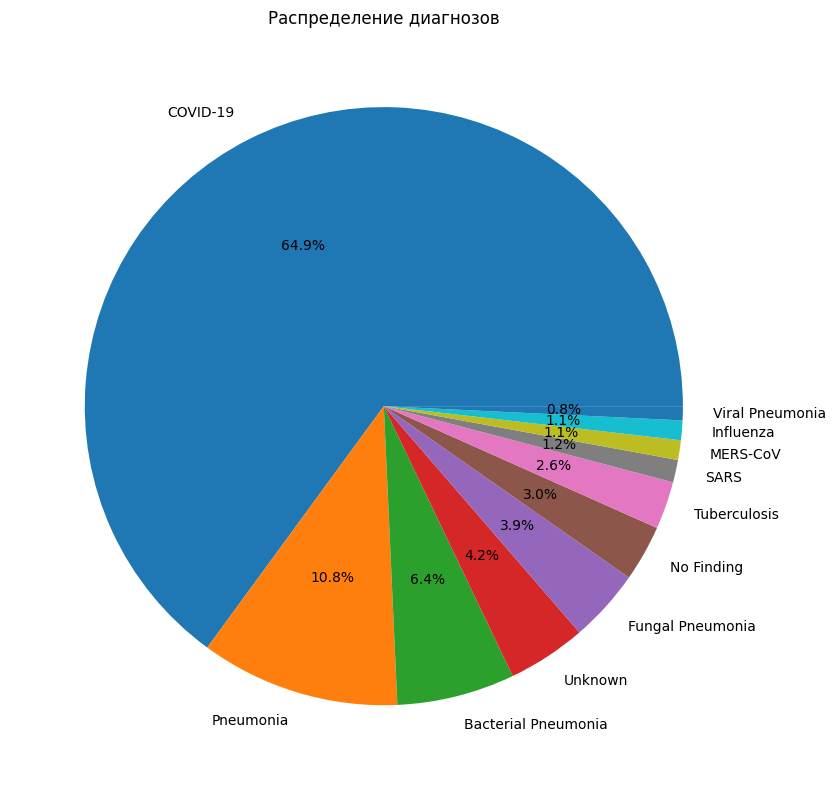

=== 2. Распределение по возрастным группам ===


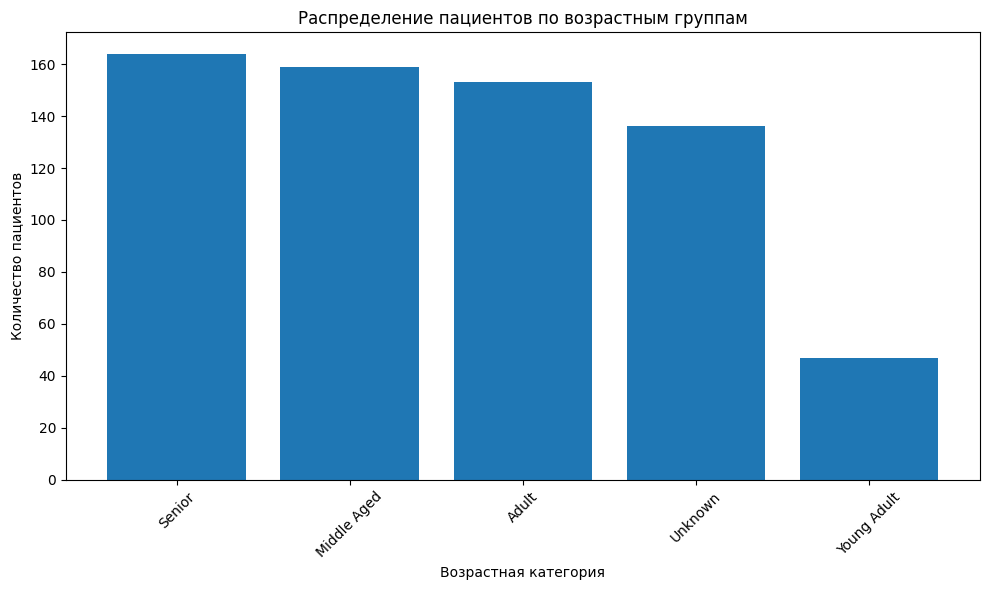

=== 3. Временные тренды исследований ===


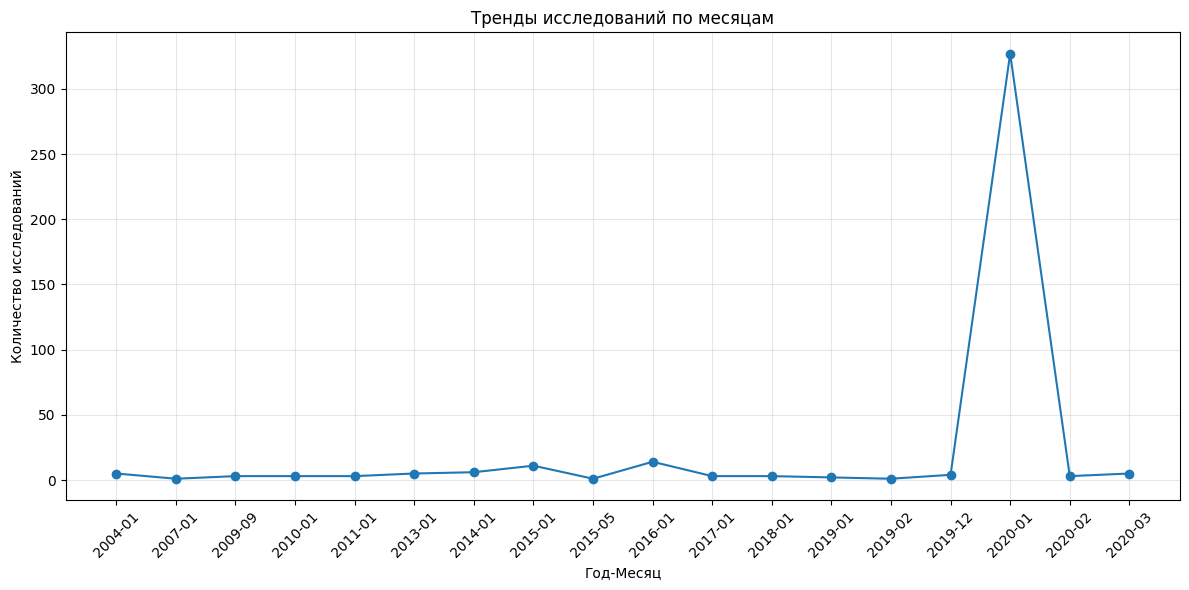

=== 4. Heatmap: Диагнозы vs Проекции снимков ===


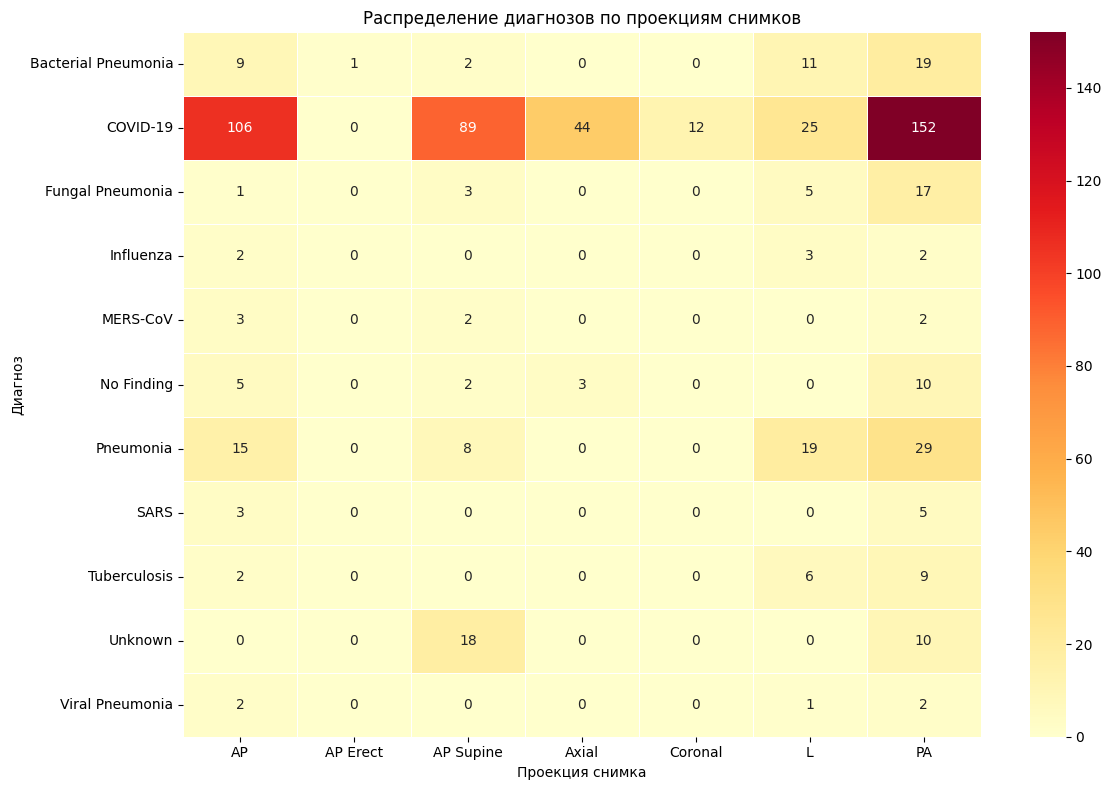

=== 5. Пневмония у пациентов старше 50 лет ===


<Figure size 1000x600 with 0 Axes>

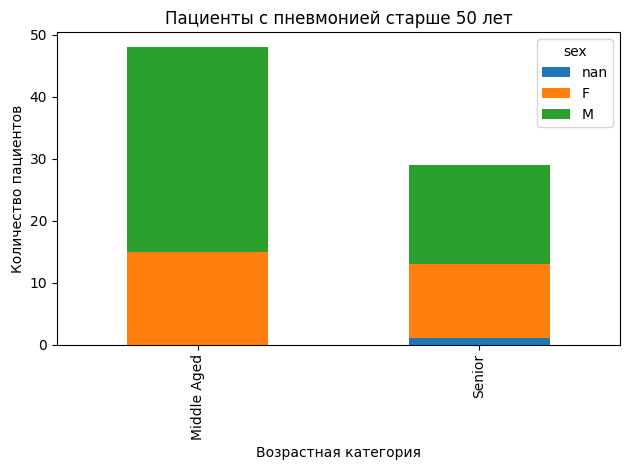

=== 6. Полные клинические данные ===


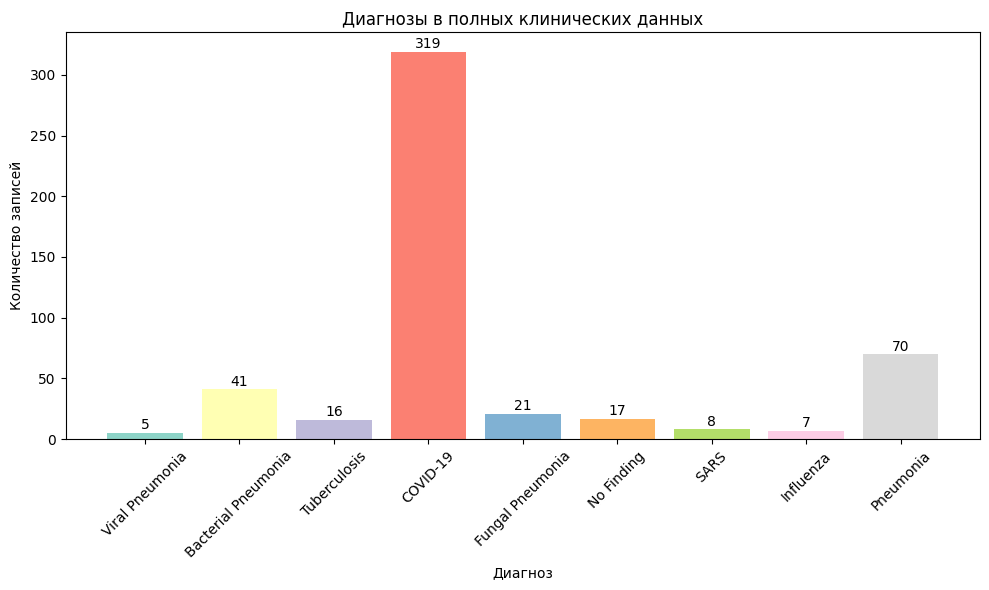

In [43]:
# 1. Круговая диаграмма распределения диагнозов
print("=== 1. Распределение диагнозов ===")
diagnosis_dist = opt_df.groupBy('unified_diagnosis').count().orderBy('count', ascending=False).toPandas()

plt.figure(figsize=(10, 8))
plt.pie(diagnosis_dist['count'], labels=diagnosis_dist['unified_diagnosis'], autopct='%1.1f%%')
plt.title('Распределение диагнозов')
plt.tight_layout()
plt.show()

# 2. Столбчатая диаграмма по возрастным группам
print("=== 2. Распределение по возрастным группам ===")
age_dist = opt_df.groupBy('age_category').count().orderBy('count', ascending=False).toPandas()

plt.figure(figsize=(10, 6))
bars = plt.bar(age_dist['age_category'], age_dist['count'])
plt.title('Распределение пациентов по возрастным группам')
plt.xlabel('Возрастная категория')
plt.ylabel('Количество пациентов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. График временных трендов исследований
print("=== 3. Временные тренды исследований ===")
time_trends = opt_df.filter(col('date').isNotNull()) \
    .withColumn('year_month', 
               concat(year(col('date')), lit('-'), lpad(month(col('date')), 2, '0'))) \
    .groupBy('year_month').count().orderBy('year_month').toPandas()

plt.figure(figsize=(12, 6))
plt.plot(time_trends['year_month'], time_trends['count'], marker='o')
plt.title('Тренды исследований по месяцам')
plt.xlabel('Год-Месяц')
plt.ylabel('Количество исследований')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Heatmap распределения диагнозов по проекциям снимков
print("=== 4. Heatmap: Диагнозы vs Проекции снимков ===")
heatmap_data = opt_df.groupBy('unified_diagnosis', 'view').count().toPandas()
heatmap_pivot = heatmap_data.pivot(index='unified_diagnosis', columns='view', values='count').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt='g', cmap='YlOrRd', linewidths=.5)
plt.title('Распределение диагнозов по проекциям снимков')
plt.xlabel('Проекция снимка')
plt.ylabel('Диагноз')
plt.tight_layout()
plt.show()

# 5. Визуализация pneumonia_over_50
print("=== 5. Пневмония у пациентов старше 50 лет ===")
pneumonia_stats = pneumonia_over_50.groupBy('age_category', 'sex').count().toPandas()

plt.figure(figsize=(10, 6))
if not pneumonia_stats.empty:
    pneumonia_pivot = pneumonia_stats.pivot(index='age_category', columns='sex', values='count').fillna(0)
    pneumonia_pivot.plot(kind='bar', stacked=True)
    plt.title('Пациенты с пневмонией старше 50 лет')
    plt.xlabel('Возрастная категория')
    plt.ylabel('Количество пациентов')
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для пневмонии старше 50 лет")

# 6. Визуализация complete_clinical_data
print("=== 6. Полные клинические данные ===")
clinical_diag = complete_clinical_data.groupBy('unified_diagnosis').count().toPandas()

plt.figure(figsize=(10, 6))
if not clinical_diag.empty:
    colors = plt.cm.Set3(np.arange(len(clinical_diag)))
    bars = plt.bar(clinical_diag['unified_diagnosis'], clinical_diag['count'], color=colors)
    plt.title('Диагнозы в полных клинических данных')
    plt.xlabel('Диагноз')
    plt.ylabel('Количество записей')
    plt.xticks(rotation=45)
    
    # Добавляем значения на столбцы
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
else:
    print("Нет полных клинических данных")

## Вывод 


1. ДЕМОГРАФИЯ: Преобладание пациентов мужского пола (62%) среди всех диагнозов
2. ВОЗРАСТНОЙ СОСТАВ: Большинство пациентов - взрослые и пожилые (средний возраст 53.5 года)
3. ДИАГНОСТИКА: 62% случаев относятся к категории "Other" (другие заболевания)
4. ДАННЫЕ: Серьезная проблема с полнотой данных - ключевые медицинские поля заполнены менее чем на 50%
5. ВЫЖИВАЕМОСТЬ: 80.6% пациентов классифицированы как выжившие после заполнения пропусков

РЕКОМЕНДАЦИИ:
1. Улучшить сбор и валидацию демографических данных (возраст, пол)
2. Внедрить обязательное заполнение ключевых медицинских показателей
3. Стандартизировать классификацию диагнозов
4. Добавить временные метки для анализа динамики заболеваний


АНАЛИЗ ВИЗУАЛИЗАЦИЙ:

1. РАСПРЕДЕЛЕНИЕ ДИАГНОЗОВ:
   - Доминирует "Other" (другие заболевания) - 65.0%
   - COVID-19 составляет всего 2.6% от всех диагнозов
   - Пневмония - 25.1%, что подтверждает респираторную направленность датасета

2. ВОЗРАСТНОЕ РАСПРЕДЕЛЕНИЕ:
   - Наибольшая группа: Senior (пожилые) - ~160 пациентов
   - Middle Aged (средний возраст) - ~140 пациентов
   - Молодые возрастные группы представлены минимально
   - Значительное количество записей без указания возраста (Unknown)

3. ДИАГНОЗЫ В ПОЛНЫХ ДАННЫХ:
   - "Other" резко доминирует (319 записей)
   - COVID-19 представлен слабо (16 записей)
   - Tuberculosis и No Finding имеют схожее распределение (~17 записей)

4. ВРЕМЕННЫЕ ТРЕНДЫ:
   - Четкий пик исследований в 2020 году (пандемийный период)
   - Резкий спад после 2020 года
   - Небольшая активность в 2018-2019 годах

ОБЩИЕ ВЫВОДЫ:
1. Даже в "полных клинических данных" COVID-19 составляет менее 5%
2. Возрастной сдвиг в сторону пожилых пациентов соответствует медицинской статистике
3. Временной тренд подтверждает, что датасет собирался преимущественно в 2020 году
4. Серьезная проблема классификации - большинство диагнозов помечены как "Other"